In [42]:
from infoVAE import MMD_VAE
from classifier import ClfNet
import torch
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import numpy as np
import copy

In [7]:
# caricamento classificatore e VAE allenati separatamente 
clf = ClfNet()
clf.load_state_dict(torch.load('./FMnist_model_1.pt'))
VAE = MMD_VAE()
VAE.load_state_dict(torch.load('./infoVAE.sd'))

<All keys matched successfully>

In [14]:

## Define a transform to read the data in as a tensor
data_transform = transforms.Compose([
                 transforms.Resize(28),
                 transforms.CenterCrop(28),
                 transforms.ToTensor()])

test_data = FashionMNIST(root='fashionmnist/', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training and test data
print('Test data, number of images: ', len(test_data))

test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Test data, number of images:  10000


In [28]:
# preparazione test set

Xtest = [i[1][0] for i in enumerate(test_loader)]
print(len(Xtest))

10000


In [147]:
index_expl = 1001 # indice istanza da spiegare



prediction = clf(Xtest[index_expl]) # classificazione istanza
sm = torch.nn.Softmax(dim=1) # funzione torch softmax

latent = VAE.encoder(Xtest[index_expl]) # codice di partenza dell'istanza da spiegare (tramite encoder)
original_prediction = sm(clf(VAE.decoder(latent)))
original_image = VAE.decoder(latent) # ricostruzione istanza da spiegare
pred_index = original_prediction.argmax().detach().numpy() #classe predetta
alpha = np.zeros(latent.shape[1])
j = 0
delta_latent = 0.1 # delta per differenze finite (f(x+dh)-f(x))/dh

for i in range(alpha.shape[0]):
    # per ogni codice generativo del VAE calcolo seguente derivata:
    # dalpha = ((probabilita' predetta perturbando codice)-(probabilita' predetta originale)/(perturbazione codice))
    # in teoria questa' derivata potrebbe essere calcolata in maniera piu' precisa usando AutoGrad sul decoder
    perturbed_latent = torch.clone(latent)
    print(perturbed_latent.shape)
    perturbed_latent[0,i] = perturbed_latent[0,i] + delta_latent
    out = sm(clf(VAE.decoder(perturbed_latent)))
    alpha[i]=(out[0,pred_index]-original_prediction[0,pred_index])/delta_latent

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])


In [148]:
prediction = pred_index
lambda_coeff = 0
while (prediction==pred_index) & (lambda_coeff <10.):
    # una volta calcolato alpha cerco il cambiamento all'immagine da spiegare necessario
    # a cambiare classificazione nella forma
    # new_image = decoder( latent + lambda * alpha)
    perturbed_latent = torch.clone(latent)
    perturbed_latent = perturbed_latent + lambda_coeff * torch.from_numpy(alpha)
    out = sm(clf(VAE.decoder(perturbed_latent.float())))
    out_image = VAE.decoder(perturbed_latent.float())
    prediction = out.argmax().detach().numpy()
    lambda_coeff+=0.1
    
# anche qui un gradient descent vero e proprio (aggiornando vettore alpha ad ogni step) sarebbe piu'opportuno
# ma stiamo solo prototipando un'idea


In [149]:
# mappa di salienza da usare come spiegazione (immagine perturbata che cambia classificazione - immagine originale)

explanation = (out_image-original_image)[0,0,:,:].detach().numpy()


In [150]:
import matplotlib.pyplot as plt


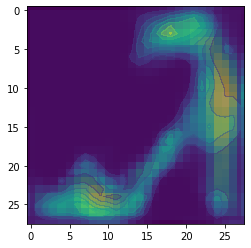

In [151]:
plt.imshow(original_image.detach().numpy()[0,0,:,:])
plt.contourf(np.abs(explanation),alpha=0.5)


tensor([[[[1.3574e-03, 2.9028e-04, 1.0305e-04, 2.7671e-04, 2.3941e-03,
           2.5533e-03, 1.1366e-03, 5.3327e-04, 6.8077e-04, 9.8753e-04,
           1.4809e-03, 2.8538e-03, 7.3025e-03, 1.6939e-02, 3.1637e-02,
           3.7784e-02, 4.1437e-02, 4.6310e-02, 6.6597e-02, 1.0094e-01,
           1.3443e-01, 1.6516e-01, 1.4464e-01, 1.1226e-01, 6.5737e-02,
           3.7187e-02, 3.0135e-02, 3.2216e-02],
          [2.1285e-04, 1.1549e-05, 1.3222e-06, 4.9345e-06, 1.3984e-04,
           3.6628e-04, 1.2827e-04, 1.7420e-05, 1.4035e-05, 2.8144e-05,
           1.1967e-04, 5.5413e-04, 3.9345e-03, 1.6825e-02, 4.6281e-02,
           7.3019e-02, 9.0600e-02, 1.0076e-01, 1.3834e-01, 2.1269e-01,
           2.7656e-01, 3.3753e-01, 2.9946e-01, 2.3347e-01, 1.2548e-01,
           5.7154e-02, 3.2738e-02, 2.8762e-02],
          [7.6634e-05, 9.4440e-07, 1.9043e-08, 2.1575e-08, 7.7778e-07,
           7.1877e-06, 4.8493e-06, 3.9285e-07, 1.5298e-07, 3.9260e-07,
           4.0646e-06, 5.4695e-05, 1.4360e-03, 1.125